In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import skimage.draw
import json
import uuid  # For generating unique IDs

# Add LLMP module to system path
sys.path.append("../")  # Adjust the path if the LLMP module is in a different location
import LLMP as L

# Define the main output directory
main_output_dir = "finetuning-EXP5-5000-10epochs-lora"

# Subdirectories for images and JSON files
image_output_dir = os.path.join(main_output_dir, "images")
json_output_dir = os.path.join(main_output_dir, "json")

# Create directories if they don't exist
os.makedirs(image_output_dir, exist_ok=True)
os.makedirs(json_output_dir, exist_ok=True)

tasks = {
    "10": "Please estimate how many dots were added to the initial 10 dots. The answer must be within the range of 1 to 10. Number only. No explanation.",
    "100": "Please estimate how many dots were added to the initial 100 dots. The answer must be within the range of 1 to 10. Number only. No explanation.",
    "1000": "Please estimate how many dots were added to the initial 1000 dots. The answer must be within the range of 1 to 10. Number only. No explanation."
}


# Number of images to generate for each task
num_images_per_task = 5000

# List to store all data from all tasks
combined_dataset = []

# Loop through each task
for task, question in tasks.items():
    print(f"Generating images and dataset for task: {task}")
    
    # Generate images and collect their labels
    for i in range(num_images_per_task):
        # Call the function to get the image and label
        image_array, label = L.GPImage.weber(task)

        # Convert the boolean array to uint8 format (0 for False, 255 for True)
        image_array_uint8 = (image_array * 255).astype(np.uint8)

        # Convert the NumPy array to a PIL image
        pil_image = Image.fromarray(image_array_uint8)

        # Generate a unique ID for the image
        unique_id = str(uuid.uuid4())

        # Save the image with the unique ID
        image_filename = os.path.join(image_output_dir, f"{unique_id}.jpg")
        pil_image.save(image_filename)

        # Create a JSON entry for the dataset
        json_entry = {
            'id': unique_id,               # Unique ID for the image
            'image': f"{unique_id}.jpg",   # Image filename
            'question': question,          # Corresponding question for the task
            'value': label                 # The label generated for the image
        }

        # Append the JSON entry to the combined dataset list
        combined_dataset.append(json_entry)

# Save the combined dataset as a single JSON file in the JSON folder
combined_json_filename = "combined_dataset.json"
combined_json_filepath = os.path.join(json_output_dir, combined_json_filename)

with open(combined_json_filepath, 'w') as json_file:
    json.dump(combined_dataset, json_file, indent=4)

print(f"Images saved in '{image_output_dir}' and combined dataset saved as '{combined_json_filename}' in '{json_output_dir}'")

# Load and display the combined JSON dataset
json_file = os.path.join(json_output_dir, "combined_dataset.json")
image_folder = image_output_dir

with open(json_file, 'r') as f:
    data = json.load(f)

# Display the first 9 images and their corresponding info
for entry in data[:9]:
    image_path = os.path.join(image_folder, entry['image'])
    img = Image.open(image_path)
    img.show()  # Opens the image using the default image viewer

    print(f"ID: {entry['id']}")
    print(f"Question: {entry['question']}")
    print(f"Value: {entry['value']}")
    print(f"Image path: {image_path}")
    print("-" * 40)


Generating images and dataset for task: 10
Generating images and dataset for task: 100
Generating images and dataset for task: 1000
Images saved in 'finetuning-EXP5-5000-10epochs-lora/images' and combined dataset saved as 'combined_dataset.json' in 'finetuning-EXP5-5000-10epochs-lora/json'
ID: f3b4b48b-d80b-453c-ae01-87fc3dfdf29d
Question: Please estimate how many dots were added to the initial 10 dots. The answer must be within the range of 1 to 10. Number only. No explanation.
Value: 1
Image path: finetuning-EXP5-5000-10epochs-lora/images/f3b4b48b-d80b-453c-ae01-87fc3dfdf29d.jpg
----------------------------------------
ID: 1ce481dc-f788-445d-9e25-d20f54ba740f
Question: Please estimate how many dots were added to the initial 10 dots. The answer must be within the range of 1 to 10. Number only. No explanation.
Value: 7
Image path: finetuning-EXP5-5000-10epochs-lora/images/1ce481dc-f788-445d-9e25-d20f54ba740f.jpg
----------------------------------------
ID: 4b370fb8-b9d9-42ab-bff4-fc368

In [2]:
import pandas as pd

# Path to the JSON file
json_file_path = 'outputweber/json/combined_dataset.json'

# Load JSON file into a DataFrame
try:
    df = pd.read_json(json_file_path)
    print("JSON file loaded successfully.")
except ValueError:
    print("Error loading JSON file. Please check the file path and format.")

# Define tasks and associated questions for different initial dot counts
task_descriptions = {
    "10": "Please estimate how many dots were added to the initial 10 dots.",
    "100": "Please estimate how many dots were added to the initial 100 dots.",
    "1000": "Please estimate how many dots were added to the initial 1000 dots."
}

# Function to get the distribution for a specified task, allowing either simplified or full task description
def get_task_distribution(df, task_key):
    # Check if 'question' column is in the DataFrame
    if 'question' not in df.columns:
        print("Column 'question' not found in the DataFrame.")
        return

    # Check if task_key is in the dictionary; if so, use the full description
    if task_key in task_descriptions:
        task_description = task_descriptions[task_key]
    elif task_key in task_descriptions.values():
        task_description = task_key
    else:
        print("Task not found. Please provide a valid task name or description.")
        return

    # Set display options to show all rows and columns
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)  # Set to None to display full cell content

    # Filter the DataFrame to include only rows where 'question' matches the given task description
    task_df = df[df['question'] == task_description]

    # Check if task_df is empty
    if task_df.empty:
        print(f"No data found for task: {task_description}")
        return

    # Group by 'value' within the filtered DataFrame to get the distribution and count
    distribution = task_df.groupby(['value']).size().reset_index(name='count')

    # Sort by 'value' in ascending order
    distribution = distribution.sort_values(by='value', ascending=True)

    # Display the sorted distribution DataFrame
    print(distribution)

# Example usage
get_task_distribution(df, "10")  # Using a key to get the question for 10 dots


JSON file loaded successfully.
   value  count
0      1    507
1      2    460
2      3    503
3      4    509
4      5    482
5      6    499
6      7    527
7      8    497
8      9    519
9     10    497


In [4]:
get_task_distribution(df, "1000")  # Using a key to get the question for 10 dots


   value  count
0      1    495
1      2    467
2      3    468
3      4    505
4      5    516
5      6    508
6      7    512
7      8    472
8      9    554
9     10    503


In [9]:
pwd

'/home/huuthanhvy.nguyen001/tmp/LLMP/EXP'

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import skimage.draw
import json
import uuid  # For generating unique IDs

# Add LLMP module to system path
sys.path.append("../")  # Adjust the path if the LLMP module is in a different location
import LLMP as L

# Define the main output directory
main_output_dir = "outputWEBER"

# Subdirectories for images and JSON files
image_output_dir = os.path.join(main_output_dir, "images")
json_output_dir = os.path.join(main_output_dir, "json")

# Create directories if they don't exist
os.makedirs(image_output_dir, exist_ok=True)
os.makedirs(json_output_dir, exist_ok=True)

# Define tasks and associated questions for different initial dot counts
tasks = {
    "10": "Please estimate how many dots were added to the initial 10 dots.",
    "100": "Please estimate how many dots were added to the initial 100 dots.",
    "1000": "Please estimate how many dots were added to the initial 1000 dots."
}

# Number of images to generate for each task
num_images_per_task = 5000

# List to store all data from all tasks
combined_dataset = []

# Loop through each task
for task, question in tasks.items():
    print(f"Generating images and dataset for task: {task}")
    
    # Generate images and collect their labels
    for i in range(num_images_per_task):
        # Call the function to get the image and label
        image_array, label = L.GPImage.weber(task)

        # Convert the boolean array to uint8 format (0 for False, 255 for True)
        image_array_uint8 = (image_array * 255).astype(np.uint8)

        # Convert the NumPy array to a PIL image
        pil_image = Image.fromarray(image_array_uint8)

        # Generate a unique ID for the image
        unique_id = str(uuid.uuid4())

        # Save the image with the unique ID
        image_filename = os.path.join(image_output_dir, f"{unique_id}.jpg")
        pil_image.save(image_filename)

        # Create a JSON entry for the dataset
        json_entry = {
            'id': unique_id,               # Unique ID for the image
            'image': f"{unique_id}.jpg",   # Image filename
            'question': question,          # Corresponding question for the task
            'value': label                 # The label generated for the image
        }

        # Append the JSON entry to the combined dataset list
        combined_dataset.append(json_entry)

# Save the combined dataset as a single JSON file in the JSON folder
combined_json_filename = "combined_dataset.json"
combined_json_filepath = os.path.join(json_output_dir, combined_json_filename)

with open(combined_json_filepath, 'w') as json_file:
    json.dump(combined_dataset, json_file, indent=4)

print(f"Images saved in '{image_output_dir}' and combined dataset saved as '{combined_json_filename}' in '{json_output_dir}'")

# Load and display the combined JSON dataset
json_file = os.path.join(json_output_dir, "combined_dataset.json")
image_folder = image_output_dir

with open(json_file, 'r') as f:
    data = json.load(f)

# Display the first 9 images and their corresponding info
for entry in data[:9]:
    image_path = os.path.join(image_folder, entry['image'])
    img = Image.open(image_path)
    img.show()  # Opens the image using the default image viewer

    print(f"ID: {entry['id']}")
    print(f"Question: {entry['question']}")
    print(f"Value: {entry['value']}")
    print(f"Image path: {image_path}")
    print("-" * 40)


ModuleNotFoundError: No module named 'skimage'

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Path to the JSON dataset and image folder
json_file = "outputweber/json/combined_dataset.json"
image_folder = "outputweber/images"

# Load the combined dataset
with open(json_file, 'r') as f:
    data = json.load(f)

# Function to plot label distribution for each task
def plot_label_distribution(task_name, data):
    # Filter entries for the specified task
    task_data = [entry for entry in data if entry['question'].endswith(f"initial {task_name} dots.")]
    
    # Extract labels (dot counts added) for distribution analysis
    labels = [entry['value'] for entry in task_data]
    
    # Plot histogram of labels
    plt.figure(figsize=(8, 6))
    plt.hist(labels, bins=np.arange(min(labels), max(labels) + 1) - 0.5, edgecolor='black')
    plt.title(f"Distribution of Dots Added for Initial {task_name} Dots")
    plt.xlabel("Number of Dots Added")
    plt.ylabel("Frequency")
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# Plot distributions for each task type
plot_label_distribution("10", data)
plot_label_distribution("100", data)
plot_label_distribution("1000", data)

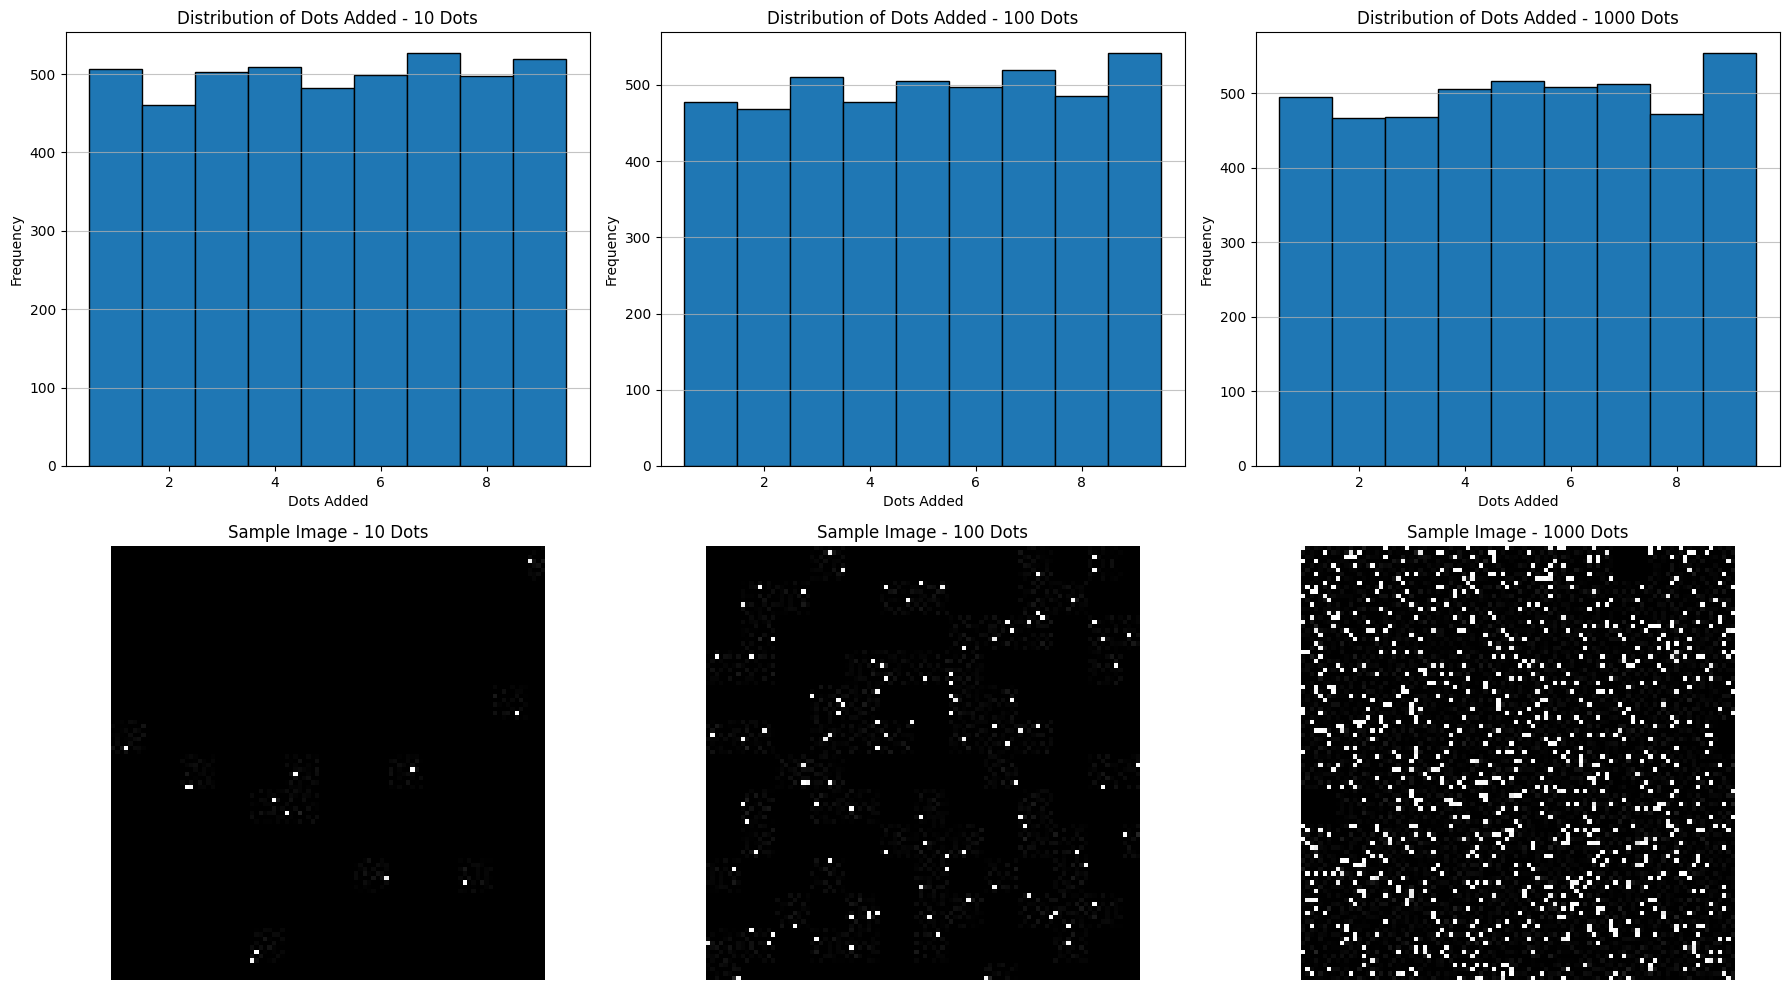

In [7]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Path to the JSON dataset and image folder
json_file = "outputweber/json/combined_dataset.json"
image_folder = "outputweber/images"

# Load the combined dataset
with open(json_file, 'r') as f:
    data = json.load(f)

# Define tasks with labels for display
tasks = {
    "10": "10 Dots",
    "100": "100 Dots",
    "1000": "1000 Dots"
}

# Set up the plotting grid for histograms and images
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  # 2 rows, 3 columns for histograms and images

# Loop through each task to plot distributions and images
for idx, (task_name, display_name) in enumerate(tasks.items()):
    # Filter entries for the specified task
    task_data = [entry for entry in data if entry['question'].endswith(f"initial {task_name} dots.")]
    
    # Extract labels (dot counts added) for distribution analysis
    labels = [entry['value'] for entry in task_data]
    
    # Plot histogram in the top row
    axes[0, idx].hist(labels, bins=np.arange(min(labels), max(labels) + 1) - 0.5, edgecolor='black')
    axes[0, idx].set_title(f"Distribution of Dots Added - {display_name}")
    axes[0, idx].set_xlabel("Dots Added")
    axes[0, idx].set_ylabel("Frequency")
    axes[0, idx].grid(axis='y', alpha=0.75)

    # Display a single image for each task in the bottom row
    sample_entry = task_data[0]  # Take the first sample for each task
    img_path = os.path.join(image_folder, sample_entry['image'])
    img = Image.open(img_path)
    
    # Display the sample image in the bottom row
    axes[1, idx].imshow(img, cmap='gray')
    axes[1, idx].set_title(f"Sample Image - {display_name}")
    axes[1, idx].axis('off')  # Hide axis for image display

plt.tight_layout()
plt.show()
